In [23]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

metop = 'MetOP_B'

In [24]:
ds= xr.open_dataset(f"/srv/data2/srai_poseidon/srai_poseidon/observation/SatelliteVsBuoy/downloads/Buoy/TAO_data/WINDS/{metop}/T_000N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Buoy_Glorys_Wave_Matchup.nc")
ds

<xarray.Dataset>
Dimensions:            (AS_TIME: 1234, NUMCELLS: 3, HEIGHT: 3, DEPTH: 1)
Coordinates:
  * AS_TIME            (AS_TIME) datetime64[ns] 2014-10-29T22:04:30 ... 2020-...
  * NUMCELLS           (NUMCELLS) int64 0 1 2
  * HEIGHT             (HEIGHT) float32 3.0 4.0 10.0
  * DEPTH              (DEPTH) float32 1.0
Data variables: (12/83)
    wvc_index          (AS_TIME, NUMCELLS) float64 ...
    model_speed        (AS_TIME, NUMCELLS) float64 ...
    model_dir          (AS_TIME, NUMCELLS) float64 ...
    ice_prob           (AS_TIME, NUMCELLS) float64 ...
    ice_age            (AS_TIME, NUMCELLS) float64 ...
    wvc_quality_flag   (AS_TIME, NUMCELLS) float64 ...
    ...                 ...
    vo                 (AS_TIME) float32 ...
    zos                (AS_TIME) float32 ...
    uo                 (AS_TIME) float32 ...
    thetao             (AS_TIME) float32 ...
    so                 (AS_TIME) float32 ...
    GLORYS_TIME        (AS_TIME) datetime64[ns] ...

In [25]:
flag_dict = {
    f'{meaning:41s}': bin(mask)[2:].zfill(23)
    for meaning, mask in zip(ds.wvc_quality_flag.flag_meanings.split(), ds.wvc_quality_flag.flag_masks)
}
flag_dict

{'distance_to_gmf_too_large                ': '00000000000000001000000',
 'data_are_redundant                       ': '00000000000000010000000',
 'no_meteorological_background_used        ': '00000000000000100000000',
 'rain_detected                            ': '00000000000001000000000',
 'rain_flag_not_usable                     ': '00000000000010000000000',
 'small_wind_less_than_or_equal_to_3_m_s   ': '00000000000100000000000',
 'large_wind_greater_than_30_m_s           ': '00000000001000000000000',
 'wind_inversion_not_successful            ': '00000000010000000000000',
 'some_portion_of_wvc_is_over_ice          ': '00000000100000000000000',
 'some_portion_of_wvc_is_over_land         ': '00000001000000000000000',
 'variational_quality_control_fails        ': '00000010000000000000000',
 'knmi_quality_control_fails               ': '00000100000000000000000',
 'product_monitoring_event_flag            ': '00001000000000000000000',
 'product_monitoring_not_used              ': '0001

In [26]:
def getSubDF(ds, LAT, LON):
    subds = xr.Dataset()

    taoTimeVar = ['TAO_TIME']
    
    windVars = ['WDIR',
         'WDIR_QC',
         'WDIR_DM',
         'WSPD',
         'WSPD_QC',
         'WSPD_DM',
         'UWND',
         'VWND']

    sstVars = ['SST',
             'SST_QC',
             'SST_DM']
    
    airtVars = ['AIRT',
             'AIRT_QC',
             'AIRT_DM']
    
    rhVars = ['RELH',
             'RELH_QC',
             'RELH_DM']
    
    u10Vars =['WSPD_10N',
             'WSPD_10']

    statVars = ['mean_WSPD',
            'std_WSPD', 
            'mean_WSPD_10N',
            'std_WSPD_10N',
            'mean_SST',
            'std_SST',
            'mean_AIRT',
            'std_AIRT',
            'mean_RELH',
            'std_RELH',
            'mean_SST - AIRT',
            'std_SST - AIRT',
            'mean_WDIR',
            'std_WDIR',
            'mean_cosWDIR',
            'std_cosWDIR',
            'mean_sinWDIR',
            'std_sinWDIR']
    
    satVars = ['wind_speed',
             'wind_dir',
             'wvc_quality_flag',
             'model_speed',
             'model_dir',
             'bs_distance',
             'dist_from_TAO_pos']

    waveVars = ['VHM0',
                 'VHM0_SW1',
                 'VHM0_SW2',
                 'VHM0_WW',
                 'VMDR',
                 'VMDR_SW1',
                 'VMDR_SW2',
                 'VMDR_WW',
                 'VPED',
                 'VSDX',
                 'VSDY',
                 'VTM01_SW1',
                 'VTM01_SW2',
                 'VTM01_WW',
                 'VTM02',
                 'VTM10',
                 'VTPK',
                 'WAVE_TIME']

    oceanVars = ['vo',
                 'zos',
                 'uo',
                 'thetao',
                 'so',
                 'GLORYS_TIME']
 
    
    for windVar in windVars:
        subds[windVar] = ds[windVar].sel(HEIGHT=4)
    subds.drop_vars('HEIGHT')
    for sstVar in sstVars:
        subds[sstVar] = ds[sstVar].sel(DEPTH=1)
    subds.drop_vars('DEPTH')
    for rhVar in rhVars:
        subds[rhVar] = ds[rhVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for airtVar in airtVars:
        subds[airtVar] = ds[airtVar].sel(HEIGHT=3)
    subds.drop_vars('HEIGHT')
    for u10Var in u10Vars:
        subds[u10Var] = ds[u10Var].sel(HEIGHT=10)
    subds.drop_vars('HEIGHT')

    for var in waveVars:
        subds[var] = ds[var]

    for var in oceanVars:
        subds[var] = ds[var]

    for statVar in statVars:
        subds[statVar] = ds[statVar]

    subds['LATITUDE'] = xr.DataArray(LAT * np.ones(len(subds['AS_TIME']), dtype = float), dims=['AS_TIME'])
    subds['LONGITUDE'] = xr.DataArray(LON * np.ones(len(subds['AS_TIME']), dtype = float), dims=['AS_TIME'])
    
    subds['TAO_TIME'] = ds['TAO_TIME']

    deployFileName = f'../../../downloads/Buoy/TAO_data/WINDS/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = xr.open_dataset(deployFileName)
    startDates = np.array(ds2['startDate'])
    endDates = np.array(ds2['endDate'])

    depNum = np.zeros((len(subds['AS_TIME'])), dtype=int)
    c = 1
    for i in range(1,len(startDates)):
        mask = subds['AS_TIME'] >= startDates[i]
        mask *= subds['AS_TIME'] <= endDates[i]
        depNum[mask] = c
        c = c+1

    subds['Deployment index'] = xr.DataArray(depNum, dims=['AS_TIME'])
    
    
    satDS = ds[satVars]
    satDS = satDS.isel(NUMCELLS=0)    
    
    returnDS = xr.merge((subds, satDS))

    
    
    return returnDS

In [27]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)


allDS = xr.Dataset()
dataCount = 0
fileCount = 0
for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
    else:
        lonUnits = 'E'

    LON = (LON+360)%360
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../../downloads/Buoy/TAO_data/WINDS/{metop}/T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_2013_2020_2hrMeanVar_AS_Buoy_Glorys_Wave_Matchup.nc'
    #deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        print(f'T_{lat:03d}{latUnits}_{lon:03d}{lonUnits}_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc')
        rds = xr.open_dataset(matchFname)
        ds = getSubDF(rds, LAT, LON)
        AS_TIME = ds['AS_TIME'].to_numpy()
        ds = ds.rename({'AS_TIME':'count'})
        dataLen = len(ds['count'])
        print(dataCount, dataCount+dataLen)
        ds['count'] = xr.DataArray(pd.Series(np.arange(dataCount, dataCount+dataLen)), 
                                   dims = ['count'])
        ds['AS_TIME'] = xr.DataArray(AS_TIME, 
                                   dims = ['count'])
        dataCount += dataLen
        if fileCount == 0:
            allDS = ds
        else:
            allDS = xr.concat((allDS, ds), dim='count')
        fileCount += 1
        

T_008S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
0 509
T_008S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
509 1557
T_008S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

1557 2808
T_008S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

2808 3483
T_008S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

3483 4017
T_008S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

4017 4534
T_008S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

4534 4973
T_005S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

4973 5802
T_005S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

5802 7149
T_005S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

7149 8107
T_005S_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

8107 9211
T_005S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

9211 9786
T_005S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

9786 10408
T_005S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

10408 11020
T_005S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

11020 11118
T_002S_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

11118 11550
T_002S_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

11550 12404
T_002S_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

12404 13017
T_002S_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

13017 13514
T_002S_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

13514 13912
T_002S_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

13912 14539


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_002S_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
14539 15440


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_002S_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
15440 16298


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_000N_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
16298 16601


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_000N_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
16601 16992


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_000N_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
16992 17869


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_000N_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
17869 18620


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
18620 19625


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_000N_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
19625 20239


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_000N_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
20239 21071


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_000N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
21071 22305


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
22305 22817


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_002N_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
22817 23487


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
23487 24137


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_002N_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
24137 24769


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
24769 25295


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_002N_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
25295 25928


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_002N_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
25928 26410


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_002N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
26410 26765


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
26765 27266


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_005N_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
27266 28412


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
28412 29091


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_005N_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
29091 30041


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
30041 30661


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_005N_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
30661 31241


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_005N_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
31241 31781


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_005N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
31781 32674


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_008N_095W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
32674 33200


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_008N_110W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
33200 33745


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_125W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
33745 34678


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_008N_155W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
34678 34887


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_008N_170W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
34887 35267


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


T_008N_180W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
35267 35913


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_008N_165E_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
35913 36936


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

T_009N_140W_COARE3p5_2013_2020_2hrMeanVar_AS_Matchup.nc
36936 37990


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho

In [28]:
allDS

<xarray.Dataset>
Dimensions:            (count: 37990)
Coordinates:
  * count              (count) int64 0 1 2 3 4 ... 37985 37986 37987 37988 37989
    HEIGHT             float32 4.0
    DEPTH              float32 1.0
    NUMCELLS           int64 0
Data variables: (12/73)
    WDIR               (count) float32 120.0 130.0 110.0 ... 131.0 226.0 199.0
    WDIR_QC            (count) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WDIR_DM            (count) |S1 b'D' b'D' b'D' b'D' ... b'D' b'D' b'D' b'D'
    WSPD               (count) float32 6.65 6.93 5.07 6.84 ... 2.68 7.46 8.54
    WSPD_QC            (count) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WSPD_DM            (count) |S1 b'D' b'D' b'D' b'D' ... b'D' b'D' b'D' b'D'
    ...                 ...
    wvc_quality_flag   (count) float64 0.0 0.0 0.0 0.0 ... 0.0 2.048e+03 0.0 0.0
    model_speed        (count) float64 6.03 6.75 5.5 6.69 ... 3.09 6.11 9.33
    model_dir          (count) float64 316.2 297.5 321.0 ... 305.2 253.2 250.7
    bs_distance        (count) float64 0.2 0.0 0.5 0.0 -0.3 ... 0.0 0.1 0.1 -1.2
    dist_from_TAO_pos  (count) float64 10.74 11.18 11.44 ... 10.53 12.62 12.56
    AS_TIME            (count) datetime64[ns] 2014-03-28T03:27:07 ... 2020-11...

In [29]:
allDS = allDS.drop_vars(['HEIGHT','DEPTH','NUMCELLS'])

In [30]:
allDS

<xarray.Dataset>
Dimensions:            (count: 37990)
Coordinates:
  * count              (count) int64 0 1 2 3 4 ... 37985 37986 37987 37988 37989
Data variables: (12/73)
    WDIR               (count) float32 120.0 130.0 110.0 ... 131.0 226.0 199.0
    WDIR_QC            (count) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WDIR_DM            (count) |S1 b'D' b'D' b'D' b'D' ... b'D' b'D' b'D' b'D'
    WSPD               (count) float32 6.65 6.93 5.07 6.84 ... 2.68 7.46 8.54
    WSPD_QC            (count) float32 2.0 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    WSPD_DM            (count) |S1 b'D' b'D' b'D' b'D' ... b'D' b'D' b'D' b'D'
    ...                 ...
    wvc_quality_flag   (count) float64 0.0 0.0 0.0 0.0 ... 0.0 2.048e+03 0.0 0.0
    model_speed        (count) float64 6.03 6.75 5.5 6.69 ... 3.09 6.11 9.33
    model_dir          (count) float64 316.2 297.5 321.0 ... 305.2 253.2 250.7
    bs_distance        (count) float64 0.2 0.0 0.5 0.0 -0.3 ... 0.0 0.1 0.1 -1.2
    dist_from_TAO_pos  (count) float64 10.74 11.18 11.44 ... 10.53 12.62 12.56
    AS_TIME            (count) datetime64[ns] 2014-03-28T03:27:07 ... 2020-11...

In [31]:
flag_dict = {
    f'{meaning:41s}': bin(mask)[2:].zfill(23)
    for meaning, mask in zip(ds.wvc_quality_flag.flag_meanings.split(), ds.wvc_quality_flag.flag_masks)
}
flag_dict

{'distance_to_gmf_too_large                ': '00000000000000001000000',
 'data_are_redundant                       ': '00000000000000010000000',
 'no_meteorological_background_used        ': '00000000000000100000000',
 'rain_detected                            ': '00000000000001000000000',
 'rain_flag_not_usable                     ': '00000000000010000000000',
 'small_wind_less_than_or_equal_to_3_m_s   ': '00000000000100000000000',
 'large_wind_greater_than_30_m_s           ': '00000000001000000000000',
 'wind_inversion_not_successful            ': '00000000010000000000000',
 'some_portion_of_wvc_is_over_ice          ': '00000000100000000000000',
 'some_portion_of_wvc_is_over_land         ': '00000001000000000000000',
 'variational_quality_control_fails        ': '00000010000000000000000',
 'knmi_quality_control_fails               ': '00000100000000000000000',
 'product_monitoring_event_flag            ': '00001000000000000000000',
 'product_monitoring_not_used              ': '0001

In [32]:
flags = np.array(allDS['wvc_quality_flag'].to_numpy(), dtype=int)
eflags = np.array(['{:023b}'.format(val) for val in flags])

rain_detected = np.array([val[3] == '1' for val in eflags])
beam_noise_content_above_threshold = np.array([val[14] == '1' for val in eflags])
not_enough_good_sigma0_for_wind_retrieval = np.array([val[16] == '1' for val in eflags])

rainMask = np.logical_or(rain_detected, beam_noise_content_above_threshold)
rainMask = np.logical_or(rainMask, not_enough_good_sigma0_for_wind_retrieval)


In [33]:
noRainMask = ~rainMask
mask1 = allDS['WSPD_QC'].isin([1,2]).to_numpy()
mask2 = allDS['WDIR_QC'].isin([1,2]).to_numpy()
mask3 = allDS['SST_QC'].isin([1,2]).to_numpy()
mask4 = allDS['RELH_QC'].isin([1,2]).to_numpy()
mask5 = allDS['AIRT_QC'].isin([1,2]).to_numpy()

In [34]:
selectMask = np.logical_and(noRainMask, mask1)
selectMask = np.logical_and(selectMask, mask2)
selectMask = np.logical_and(selectMask, mask3)
selectMask = np.logical_and(selectMask, mask4)
selectMask = np.logical_and(selectMask, mask5)

In [35]:
for var in ['WSPD', 'WDIR', 'SST', 'RELH', 'AIRT',
           'mean_WSPD', 'mean_WDIR', 'mean_SST', 'mean_RELH', 'mean_AIRT', 'mean_SST - AIRT',
           'std_WSPD', 'std_WDIR', 'std_SST', 'std_RELH', 'std_AIRT', 'std_SST - AIRT',
           'std_cosWDIR', 'std_sinWDIR',
            'wind_speed', 'wind_dir']:
    selectMask = np.logical_and(selectMask, ~np.isnan(allDS[var].to_numpy()))

In [36]:
indices = selectMask.nonzero()[0]

In [37]:
goodDataSet = allDS.sel(count=indices)

In [38]:
goodDataSet = goodDataSet.rename_vars({'WSPD':'Wind Speed (TAO)',
                  'WDIR':'Wind Direction (TAO)',
                  'UWND': 'Zonal Wind Speed (TAO)',
                  'VWND': 'Meridional Wind Speed (TAO)',
                  'SST': 'Sea Surface Temperature (TAO)',
                  'RELH': 'Relative Humidity (TAO)',
                  'AIRT': 'Air Temperature (TAO)',
                  'WSPD_10N': 'Neutral Wind Speed at 10m (TAO)',
                  'WSPD_10': 'Wind Speed at 10m (TAO)',
                  'wind_speed': 'Wind Speed (ASCAT)',
                  'wind_dir': 'Wind Direction (ASCAT)'})

In [39]:
#goodDataSet.to_netcdf(f'goodData_ASwithTAO_{metop}.nc')

In [40]:
print(len(goodDataSet['count']))

35508


In [41]:
df = goodDataSet.copy()

In [42]:
df['Speed Difference (ASCAT - TAO)'] = df['Wind Speed (ASCAT)'] - df['Neutral Wind Speed at 10m (TAO)']

## change true degrees to degrees where 0 deg mean_east and 90 deg mean_north 
#df['Wind Direction (TAO)'] = (-(df['Wind Direction (TAO)'] - 90.0) + 360)%360
df['Wind Direction (ASCAT)'] = (-(df['Wind Direction (ASCAT)'] - 90.0) + 360)%360

## calculate zonal and meridional winds 
df['Zonal Neutral Wind Speed (TAO)'] = df['Neutral Wind Speed at 10m (TAO)'] * np.cos(np.deg2rad(df['Wind Direction (TAO)']))
df['Meridional Neutral Wind Speed (TAO)'] = df['Neutral Wind Speed at 10m (TAO)'] * np.sin(np.deg2rad(df['Wind Direction (TAO)']))

df['Zonal Wind Speed (ASCAT)'] = df['Wind Speed (ASCAT)'] * np.cos(np.deg2rad(df['Wind Direction (ASCAT)']))
df['Meridional Wind Speed (ASCAT)'] = df['Wind Speed (ASCAT)'] * np.sin(np.deg2rad(df['Wind Direction (ASCAT)']))

#### Speed and direction QS corrected to absolute using GLORYS
df['Zonal Wind Speed (ASCAT) absolute'] = df['Zonal Wind Speed (ASCAT)'] + df['uo']
df['Meridional Wind Speed (ASCAT) absolute'] = df['Meridional Wind Speed (ASCAT)'] + df['vo']

absolute_direction_QS = np.rad2deg(np.arctan2(df['Meridional Wind Speed (ASCAT) absolute'],
                                              df['Zonal Wind Speed (ASCAT) absolute']))

absolute_direction_QS = (absolute_direction_QS+360)%360

df['Wind Direction (ASCAT) absolute'] = absolute_direction_QS

## direction diff in range (-180,180)
dirDiff = ((df['Wind Direction (ASCAT)'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['Direction Difference (ASCAT - TAO)'] = dirDiff
df['cos(Direction Difference (ASCAT - TAO))'] = np.cos(np.deg2rad(dirDiff))
df['sin(Direction Difference (ASCAT - TAO))'] = np.sin(np.deg2rad(dirDiff))

df['Zonal Wind Speed Difference (ASCAT - TAO)'] = df['Zonal Wind Speed (ASCAT)'] - df['Zonal Neutral Wind Speed (TAO)']
df['Meridional Wind Speed Difference (ASCAT - TAO)'] = df['Meridional Wind Speed (ASCAT)'] - df['Meridional Neutral Wind Speed (TAO)']

## direction diff in range (-180,180) with absolute
dirDiff = ((df['Wind Direction (ASCAT) absolute'] - df['Wind Direction (TAO)'])+360)%360
dirDiff = xr.where(dirDiff > 180, dirDiff-360, dirDiff)
df['Direction Difference (ASCAT - TAO) absolute'] = dirDiff
df['cos(Direction Difference (ASCAT - TAO)) absolute'] = np.cos(np.deg2rad(dirDiff))
df['sin(Direction Difference (ASCAT - TAO)) absolute'] = np.sin(np.deg2rad(dirDiff))

df['Zonal Wind Speed Difference (ASCAT - TAO) absolute'] = df['Zonal Wind Speed (ASCAT) absolute'] - df['Zonal Neutral Wind Speed (TAO)']

df['Meridional Wind Speed Difference (ASCAT - TAO) absolute'] = df['Meridional Wind Speed (ASCAT) absolute'] - df['Meridional Neutral Wind Speed (TAO)']


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

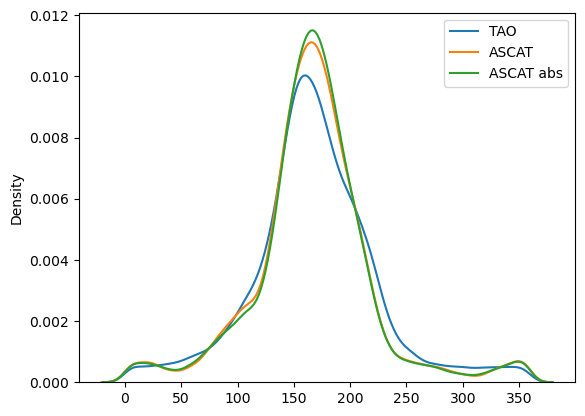

In [43]:
sns.kdeplot(df['Wind Direction (TAO)'], label = 'TAO',)
sns.kdeplot(df['Wind Direction (ASCAT)'], label = 'ASCAT')
sns.kdeplot(df['Wind Direction (ASCAT) absolute'], label = 'ASCAT abs')
plt.legend()

In [44]:
df.to_netcdf(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_{metop}_waveAndGlorysAdded.nc')

In [46]:
dsA = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_A_waveAndGlorysAdded.nc')
dsB = xr.open_dataset(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_B_waveAndGlorysAdded.nc')
dsB['count'] = dsB['count'] + np.max(dsA['count'].to_numpy()) + 1

ds = xr.concat([dsA, dsB], dim='count')
ds.to_netcdf(f'rainFlagRemovedBuoyDataBadQualityRemovedMatchup_MetOP_AB_waveAndGlorysAdded.nc')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/pytho